# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [143]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [144]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [145]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [146]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=66)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [147]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 5733, 'TN': 4024, 'FP': 5934, 'FN': 4309, 'Accuracy': 0.48785, 'Precision': 0.4913859604011314, 'Recall': 0.570902210714997, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [148]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [149]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [150]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 9679, 'TN': 9826, 'FP': 132, 'FN': 363, 'Accuracy': 0.97525, 'Precision': 0.986545713994496, 'Recall': 0.9638518223461462, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [151]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [152]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 9012, 'TN': 6259, 'FP': 3699, 'FN': 1030, 'Accuracy': 0.76355, 'Precision': 0.7089922114703799, 'Recall': 0.8974307906791475, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

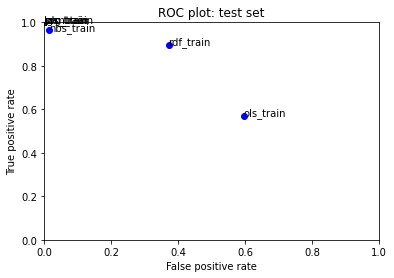

In [154]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [171]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [172]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
143
This is a pretty bad movie. But not so bad as it's reputation suggests. The production values aren't too bad and there is the odd effective scene. And it does have an 80's cheezoid veneer that means that it is always kind of fun. Watch out, too, for Jimmy Nail's brief appearance - his attempt at an American accent is so astoundingly rubbish it's fantastic. Fantastic too are Sybil Danning's breasts - they make a brief appearance in the movie but the scene is repeated umpteen times in the end credits in what can only be described as the 12\ remix of Sybil Danning's boobs. Has to be seen to be believed. As a horror movie it isn't scary, the effects are silly and Christopher Lee turns up to sleepwalk through his performance. I guess he was buying a new house and needed some cash for the deposit. The two central characters - the man and the woman - were so negligible that I have forgotten almost everything about them and I just watched this movie earlier ton

2991
I disagree with much that has been written and said about this supposed \masterpiece\" of the German New Wave: <br /><br />1) There are major flaws in simple exposition, in the basic communication of critical plot points, as relating to Maria's abortion and the secret contract between Oswald and her husband. How many viewers understood that the husband agreed, in exchange for substantial financial remuneration, not to return to and reclaim his wife until Oswald was dead?<br /><br />2) The ending is highly unsatisfying because arbitrary and accidental. The original screenplay called for Maria to commit suicide after the reading of Oswald's will, on finding out that her husband had in effect sold their marriage to Oswald. In the final version, however, Maria only runs water from a faucet across her wrist in a gesture of suicide. Maria is then summarily blown up, rather than having to confront and live with the consequences of her self-delusion and moral compromise.<br /><br />3) Fas

5137
This guy has no idea of cinema. Okay, it seems he made a few interestig theater shows in his youth, and about two acceptable movies that had success more of political reasons cause they tricked the communist censorship. This all is very good, but look carefully: HE DOES NOT KNOW HIS JOB! The scenes are unbalanced, without proper start and and, with a disordered content and full of emptiness. He has nothing to say about the subject, so he over-licitates with violence, nakedness and gutter language. How is it possible to keep alive such a rotten corpse who never understood anything of cinematographic profession and art? Why don't they let him succumb in piece?
* * * * * * * * * 
5142
I'll say one thing about this film: there are no lulls. You can't get bored watching this. The problem is that it is TOO intense. There is too much action and it NEEDS lulls! That is the risk you take in modern action films. You want it interesting but not overdone. This is way overdone.<br /><br />Even

6621
This film is overblown, predictable, pretentious, and hollow to its core. The settings are faithful to the era but self-conscious in their magnification by prolonged exposure. The lingering over artifacts stops the action and cloys almost as much as the empty dialogue. Tom Hanks seems to be sleepwalking much as Bruce Willis did in Hart's War. Tom, you can't give depth to a character simply by making your face blank! The content did not warrant the histrionic acting by Paul Newman. This is a dud wrapped in an atomic bomb casing.
* * * * * * * * * 
6692
This movie was great the first time I saw it, when it was called \Lost in Translation.\" But somehow Bill Murray turned into an eccentric black man played by Morgan Freeman, Scarlett Johansson turned into a cranky Latino woman played by Paz Vega, and Tokyo, Japan turned into Carson, California. Instead of meaningful conversations and silence we enjoyed in Translation, we get meaningless blabbering in 10 Items that verges on annoying.

8676
I can't believe it, IMDb really does have every TV show known to man! I have not seen this show in over 20 years. I only remember two episodes, and I barely remember those. I remember that Tony may not been on from the start, because one of the episodes I remember is the one in which everybody trying to get Tony to join, but he rejects them, but typically at the end of the show he becomes a member of Power House, with everybody cheering.<br /><br />The other one I remember is the one where Lolo for some reason pretends to be dead,(complete with funeral and mourners). I don't remember why he plays dead, or how the show ends.<br /><br />This is one of those shows that I convinced myself that I must have dreamed up since no one else had ever heard of it.
* * * * * * * * * 
8745
I really wanted to like this western, being a fan of the genre and a fan of \Buffalo Bill,\" \"Wild Bill Hickok,\" and \"Calamity Jane,\" all of whom are in this story! Add to the mix Gary Cooper as the lead a

10565
A top contender for worst film ever made. Joanna Pakula's character seems to have an I.Q. of 3 which is only one less than the writer and director. The screenplay would not have passed in a high school writing class; the \jokes\" are juvenile; the concept corny. These performers were obviously desperate for work. I stayed to the end only to see if it would get worse. It did. Life is too short to spend any part of it watching this film."
* * * * * * * * * 
10633
If your idea of entertainment is watching graphic footage of people being run over by cars (you get to see a woman passing under the front wheel, being twisted as the car passes over her before she goes under the back wheel -- and they show it twice in case you missed it the first time) then this is the documentary for you. Admitedly I didn't watch any more of this very disturbing piece of voyeurism, but that was enough for me. Maybe the rest is even better.<br /><br />I wonder how long it's going to take for television ne

12422
\Envy\" is bad for a number of reasons. Yes, there are unlikeable characters. That's not the problem. It is that they are unlikeable and we do not care for them at all. \"The War of the Roses\" featured unlikeable characters but due to proper introductions we grew to at least find ourselves interested in their fate, whereas in \"Envy\" the introduction is thin, the characters are never believable, and the plot only makes things worse.<br /><br />Ben Stiller is simply repulsive in his role and I'm a fan of his work most of the time. Stiller campaigned to have this released straight-to-video and now I can see why. The movie proposes that he's \"best friends\" with Jack Black, but from the first five minutes we are given footage that seems to indicate Stiller hates Black. I thought this would develop into some sort of one-sided relationship (a la \"The Cable Guy\") but it never does, instead Stiller insists he's his \"best friend\" and I felt confused as he seemed to treat Black lik

14138
There's a group of Fox TV executives sitting around a boardroom table wondering what new show to commission. <br /><br />'How about aiming for something like 24 or The West Wing?' says one of them, but they all agree it would be too expensive, and cheap TV is less likely to harm the station if it flops. <br /><br />'Well, how about getting together some great comedy writers and doing a quality sitcom?' offers another and is fired on the spot. 'Don't you know good writers cost lots of money!' the big chief barks. 'That's why we invented reality TV.'<br /><br />'We could do yet another crime drama...' suggests a man in a bland suit. 'I'm listening...' the boss replies, suddenly interested. 'People like CSI, so let's do another copy of that,' Blandman adds.<br /><br />'But there are already far too many CSI clones out there, what can we do to make ours stand out?' a naive junior enquires and is sacked instantly. 'Stand out! If we do that people may be confused! Let's give them more 

* * * * * * * * * 
16172
All the world said that the film Tashan would be a good movie with great pleasure, but this is not the case. Vijay Krishna Acharya made a serious mistake to take as an actress Kareena Kapoor. She was unbearable throughout the film. Her tom-boy look does not really goes well. Even the film the story of the film is not making sense at all. Everyone said that the Quetin Taratino of India is Vijay but its not at all Quetin. The talent Anil Kapoor was involved in this stupid movie. Anil is an actor of large caliber and this film is not. Akshay Kumar has also been a victim of this film as all is Saif. The Style and the Phoormola is not really good in this film i was disappointed
* * * * * * * * * 
16203
This service comedy, for which Peter Marshall (Joanne Dru's brother and later perennial host of The Hollywood Squares) and Tommy Noonan were hyped as 'the new Lewis and Martin' is just shy of dreadful: a few random sight gags are inserted, everyone talks fast and noth

OK.... I just have 3 words - cheesy, cheesy and CHEESY! The only redeeming feature of this movie is Dean Cain. Other than that - it's CHEESEBALL SUPREME!!!!<br /><br />The movie DOES have some promise in the concept - an underground lab creates a real live fire breathing dragon - basically giving us more of \Jurassic Park\" meets \"Reign of Fire\"..... There are some great possibilities, but they just don't follow through.... The special effects are decent - even though you KNOW the dragon is CGI, it doesn't horribly LOOK like CGI.... <br /><br />I wouldn't lay the blame on Dean Cain (although he IS one of the producers), I'd lay more of the blame on Phillip Roth - the director and writer. It's HIS job to make this film.... and, unfortunately, he failed."
* * * * * * * * * 
17934
Frankly I'm rather incensed that on the basis of the dazzling reviews attributed to Steven Smith I wasted nearly two hours on his debut offering. Have they all been written by his pals? The action clunks along

19879
I couldn't watch more than 14 minutes of it. It's a GREAT combination of really bad acting and really bad directing. The shots used are disgusting, they broke the 180 degrees angle all the time. My head hurts try to watch that load of \you know what\". Dirt on the \"mystery machine\" window make you see light from the lighting on the windows...annoying. What else... it's so badly framed all the time it's just make you want to scream at that lady directing there. I only directed short films, but I'm pretty sure I'd be way better than that directing a feature film.... the story is unbelievable, just the long french kissing scene at the beginning tell you that it's gonna be pretty awful. So pretty much, try to avoid this really bad movies at all cost, it'll save you the 5 bucks or so for the rental, and that 1h30 hour of your life you'll never get back..."
* * * * * * * * * 
19943
Let me start by saying that I totally agree with the basic thesis of the film, that there probably was 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [173]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1510, 'TN': 961, 'FP': 1581, 'FN': 948, 'Accuracy': 0.4942, 'Precision': 0.488515043675186, 'Recall': 0.6143205858421481, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [174]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2050, 'TN': 2100, 'FP': 442, 'FN': 408, 'Accuracy': 0.83, 'Precision': 0.8226324237560193, 'Recall': 0.8340113913751017, 'desc': 'svm_test'}


### MODEL: logistic regression

In [175]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2066, 'TN': 2092, 'FP': 450, 'FN': 392, 'Accuracy': 0.8316, 'Precision': 0.8211446740858506, 'Recall': 0.8405207485760781, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [176]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1819, 'TN': 1860, 'FP': 682, 'FN': 639, 'Accuracy': 0.7358, 'Precision': 0.7273090763694522, 'Recall': 0.7400325467860048, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [177]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2081, 'TN': 2067, 'FP': 475, 'FN': 377, 'Accuracy': 0.8296, 'Precision': 0.8141627543035994, 'Recall': 0.8466232709519935, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [162]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2087, 'TN': 2044, 'FP': 498, 'FN': 371, 'Accuracy': 0.8262, 'Precision': 0.8073500967117988, 'Recall': 0.8490642799023597, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [163]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2155, 'TN': 1525, 'FP': 1017, 'FN': 303, 'Accuracy': 0.736, 'Precision': 0.6793820933165196, 'Recall': 0.8767290480065093, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

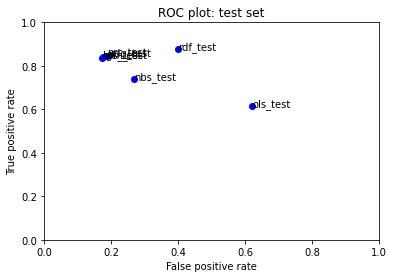

In [164]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [165]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=66, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [166]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.61648


In [167]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [168]:
my_submission.head()

,id,prediction
0,12311_10,0
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [169]:
my_submission.shape

(25000, 2)

In [170]:

# export submission file as csv
# CHANGE FILE PATH: 
my_submission.to_csv('./moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation